In [1]:
# pytesseract은 Python에서 Tesseract OCR 엔진에 액세스하기 위한 인터페이스입니다. 
# Tesseract OCR은 Google에서 개발한 오픈 소스 OCR(광학 문자 인식) 엔진으로, 이미지에서 텍스트를 추출하는 데 사용됩니다.
!pip install pytesseract

# 1.차량 이미지 파일  읽기

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

In [3]:
# text =pytesseract.image_to_string(image)

image_path='../data/car_license_plate.jpeg'

image=cv2.imread(image_path)
"""
None : 경로 오류 !!
"""
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

h_,w_,c=image.shape
print("이미지 크기 >>>",h_,w_,c)


이미지 크기 >>> 720 960 3


# 2. 차량 이미지 Grayscale 변환

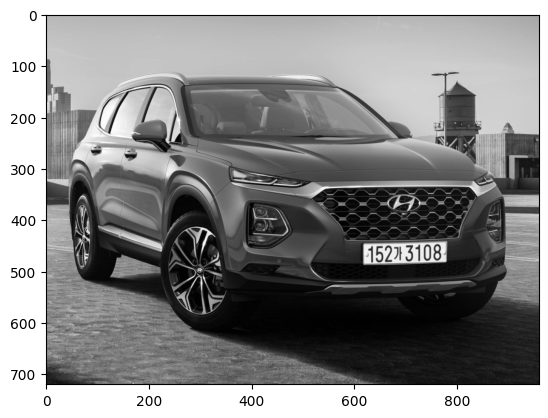

In [4]:
gray_image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image,'gray')
plt.show()

# 3. 차량 이미지 - Maximize contrast

[[1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]]


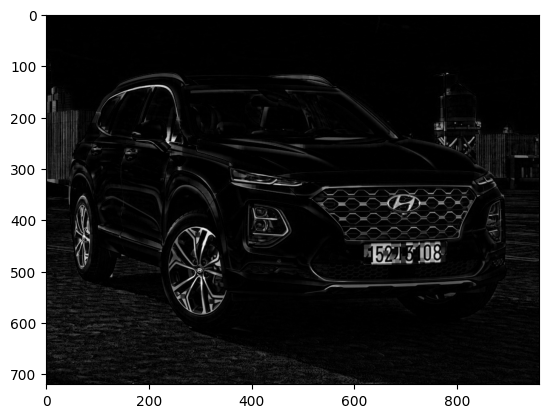

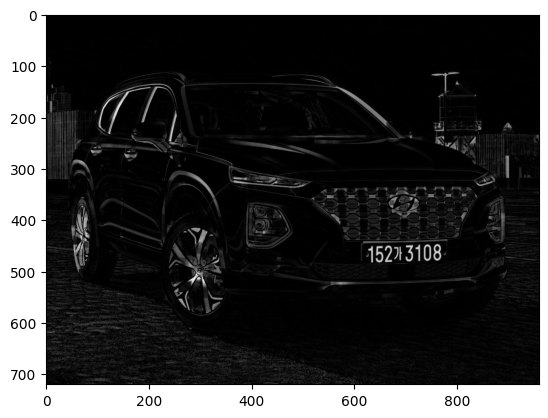

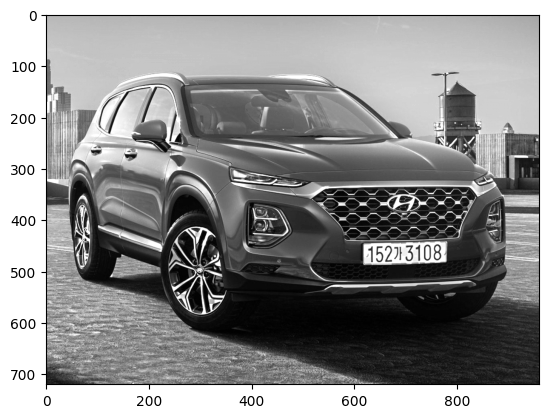

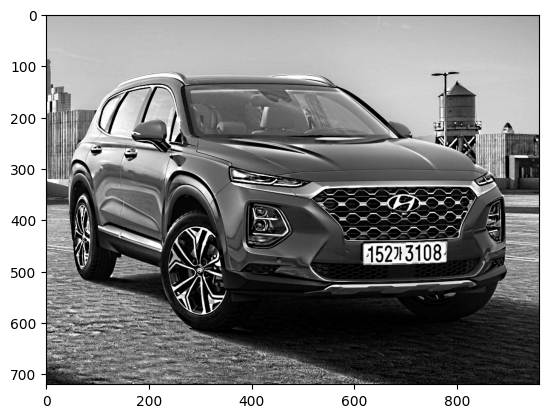

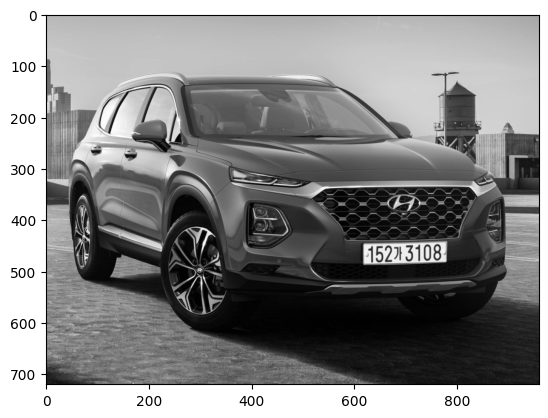

In [5]:
# 모폴로지 연산
structuringElement=cv2.getStructuringElement(cv2.MORPH_RECT, (9,9)) # 커널 값
print(structuringElement)

# TOPHAT -> 밝기 값이 크게 변화하는 영역을 강조
imgTopHat=cv2.morphologyEx(gray_image,cv2.MORPH_TOPHAT,structuringElement)

# BLACKHAT -> 어두운 부분을 강조
imgBlackHat=cv2.morphologyEx(gray_image,cv2.MORPH_BLACKHAT,structuringElement)


plt.imshow(imgTopHat,'gray')
plt.show()

plt.imshow(imgBlackHat,'gray')
plt.show()


# 합치기
imgGrayScalePlusToHat=cv2.add(gray_image,imgTopHat)
plt.imshow(imgGrayScalePlusToHat,'gray')
plt.show()

# 뺄셈 연산
gray=cv2.subtract(imgGrayScalePlusToHat,imgBlackHat)
plt.imshow(gray,'gray')
plt.show()

plt.imshow(gray_image,'gray')
plt.show()

# 4. 차량 이미지 - 이진화

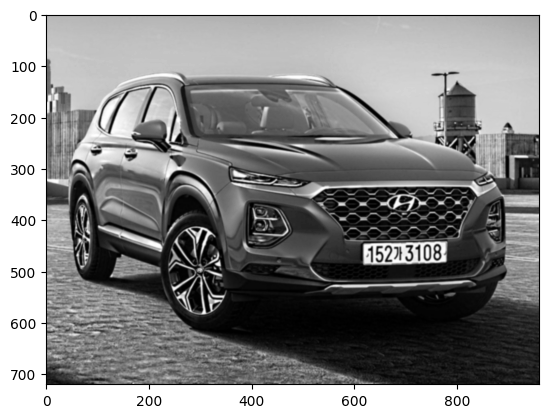

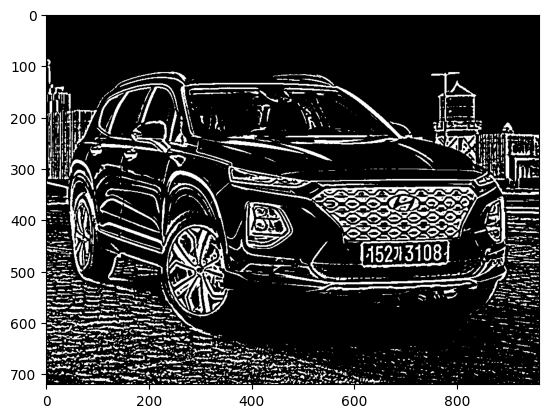

In [6]:
img_blurred=cv2.GaussianBlur(gray,ksize=(5,5),sigmaX=0)

plt.imshow(img_blurred,'gray')
plt.show()

img_thresh =cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=15,
    C=9
)
plt.imshow(img_thresh,'gray')
plt.show()

# 5. 차량 이미지 - Find Contours (이미지에서 객체의 외각선 검출)

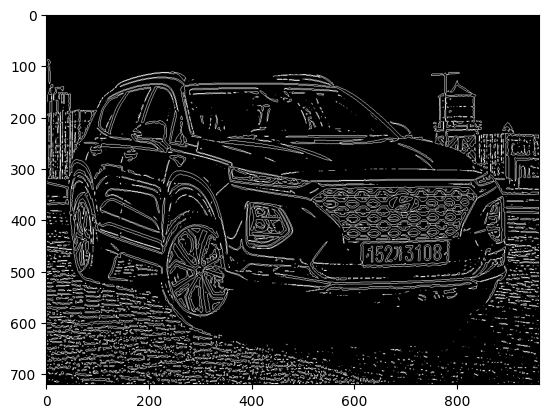

In [7]:
contours,hierarchy=cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result=np.zeros((h_,w_,c),dtype=np.uint8)

# contours 그리기
cv2.drawContours(temp_result,contours=contours,contourIdx=-1,color=(255,255,255))
plt.imshow(temp_result,'gray')
plt.show()

Canny 에지 검출은 주로 에지 검출과 관련된 작업에 사용됩니다.
findContours 함수는 이미지에서 윤곽선(contour)을 검색하는 함수입니다.
정보 반환 Canny 에지 검출과 findContours 함수는 서로 다른 기술이지만, 윤곽선을 추출하는 작업에 함께 사용될 수 있습니다. Canny 에지 검출을 통해 이미지에서 에지를 찾은 후, 해당 에지를 findContours 함수로 전달하여 윤곽선을 추출하는 방식으로 활용될 수 있습니다.

# 6. 차량 이미지 전처리(바운딩 박스 표시)

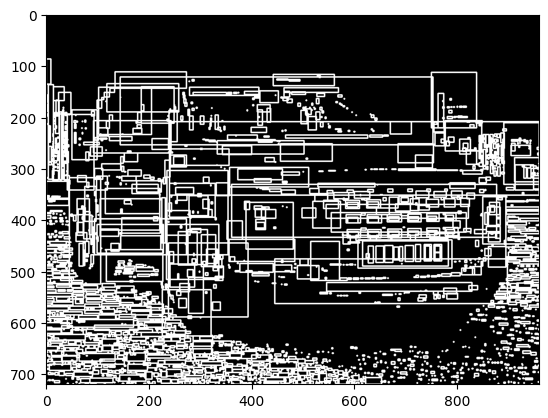

In [8]:
temp_result=np.zeros((h_,w_,c),dtype=np.uint8)

contours_dict=[]
for contour in contours:
    x,y,w,h=cv2.boundingRect(contour)
    cv2.rectangle(temp_result,(x,y),(x+w,y+h),(255,255,255),thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x':x,
        'y':y,
        'w':w,
        'h':h,
        'cx':x+(w/2),
        'cy':y+(h/2)
    })
    
# print(contours_dict)
plt.imshow(temp_result,'gray')
plt.show()

# 7. 차량 이미지 Select Candidates by char size

720 960 3


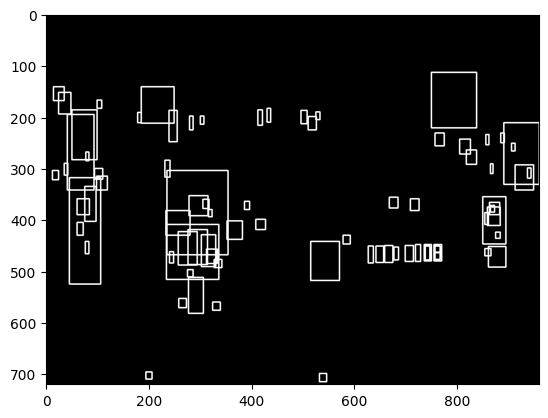

In [9]:
MIN_AREA=90
MIN_WIDTH,MIN_HEIGHT=2,8
MIN_RATIO,MAX_RATIO=0.25,1.0

possible_contours=[]

count=0
for d in contours_dict:
    area=d['w']*d['h']
    ration=d['w']/d['h']
    
    if area > MIN_AREA and d['w']> MIN_WIDTH and d['h']> MIN_HEIGHT and  MAX_RATIO> ration > MIN_RATIO:
        d['idx'] = count
        count+=1
        possible_contours.append(d)
        
print(h_,w_,c)
temp_result=np.zeros((h_,w_,c),dtype=np.uint8)

        
for d in possible_contours:
    cv2.rectangle(temp_result,pt1=(d['x'],d['y']),pt2=(d['x']+d['w'],d['y']+d['h']),color=(255,255,255),thickness=2)


plt.imshow(temp_result,'gray')
plt.show()

# 8. 차량 이미지 - Select Candidates by Arrangement of Contours 변환

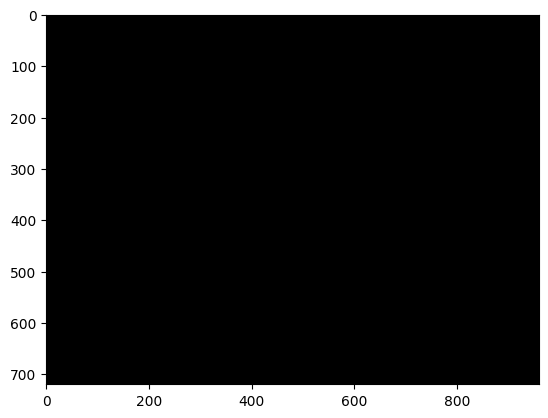

In [10]:
MAX_DIAG_MULTIPLAYER=5 # 최대 대각선 길이 배율
MAX_ANGLE_DIFF=12.0    # 최대 각도 차이
MAX_AREA_DIFF=0.5      # 최대 넓이 차이
MAX_WIDTH_DIFF=0.8     # 최대 너비 차이
MAX_HEIGHT_DIFF=0.2    # 최대 높이 차이
MIN_N_MATCHED=3        # 최소 매칭 갯수

def find_chars(contour_list):  # 윤곽선 리스트를 입력 받음
    
    matched_result_idx=[]      # 결과 index를 저장하는 list 초기화
    
    for d1 in contour_list:
        matched_contours_idx=[] #
        
        for d2 in contour_list:
            if d1['idx']==d2['idx']:
                continue
            
            dx=abs(d1['cx']-d2['cx'])
            dy=abs(d1['cy']-d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w']**2 + d1['h']**2) # 대각선의 길이
            distance=np.linalg.norm(np.array([d1['cx'],d1['cy']])-np.array([d2['cx'],d2['cy']])) # 중심좌표를 이용해 거리를 구함
            
            if dx==0:
                angle_diff=90
            else:
                angle_diff=np.degrees(np.arctan(dy/dx))
           
            area_diff=abs(d1['w']*d1['h']-d2['w']*d2['h'])/(d1['w']*d1['h'])
            width_diff=abs(d1['w']-d2['w']/d1['w'])
            height_diff=abs(d1['h']-d2['h']/d1['h'])
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLAYER and angle_diff < MAX_ANGLE_DIFF \
            and area_diff < MAX_AREA_DIFF and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx)<MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contour_idx)
        
        unmatched_contour_idx=[]
        
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
                
        unmatched_contour=np.take(possible_contours,unmatched_contour_idx)

        
        # recursive
        recursive_contour_list=find_chars[unmatched_contour]
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
        break
        
    return matched_result_idx
        
result_idx=find_chars(possible_contours)

matched_result=[]
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours,idx_list))

temp_result=np.zeros((h_,w_,c),dtype=np.uint8)

for r in matched_result:
    for d in r :
        x1_temp=d['x']
        y1_temp=d['y']
        w1_temp=d['w']
        h1_temp=d['h']
        cv2.rectangle(temp_result,(x1_temp,y1_temp),(x1_temp+w1_temp,y1_temp+h1_temp),(255,255,255),thickness=2)
        
plt.imshow(temp_result,'gray')
plt.show()